In [0]:
import os
import seaborn as sn
import pandas as pd
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Activation, Dropout, GlobalAveragePooling2D, \
BatchNormalization, concatenate, AveragePooling2D
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense,Reshape
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import tensorflow as tf
from pathlib import Path
import cv2
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
tf.set_random_seed(1234)

Using TensorFlow backend.


In [0]:
from google.colab import drive

drive.mount('/content/gdrive')
#os.listdir('../input')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


image=64*64    rotation=60

In [0]:
train_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                              rescale = 1./255, 
                             #rescale = 0.8, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

train = train_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/train_mix_Norm/",
                                            class_mode="categorical",
                                            target_size=(64,64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 8222 images belonging to 2 classes.


In [0]:
valid_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255,
                             #rescale = 0.8, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

valid = valid_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/valid_mix_norm/",
                                            class_mode="categorical",
                                            target_size=(64, 64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 750 images belonging to 2 classes.


In [0]:
def conv_layer(conv_x, filters):
    conv_x = BatchNormalization()(conv_x)
    conv_x = Activation('relu')(conv_x)
    conv_x = Conv2D(filters, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(conv_x)
    conv_x = Dropout(0.2)(conv_x)
    #conv_x = Dropout(0.2)(conv_x)
    #conv_x = Dropout(0.3)(conv_x) 

    return conv_x


def dense_block(block_x, filters, growth_rate, layers_in_block):
    for i in range(layers_in_block):
        each_layer = conv_layer(block_x, growth_rate)
        block_x = concatenate([block_x, each_layer], axis=-1)
        filters += growth_rate

    return block_x, filters


def transition_block(trans_x, tran_filters):
    trans_x = BatchNormalization()(trans_x)
    trans_x = Activation('relu')(trans_x)
    trans_x = Conv2D(tran_filters, (1, 1), kernel_initializer='he_uniform', padding='same', use_bias=False)(trans_x)
    trans_x = AveragePooling2D((2, 2), strides=(2, 2))(trans_x)

    return trans_x, tran_filters


def dense_net(filters, growth_rate, classes, dense_block_size, layers_in_block):
    input_img = Input(shape=(64, 64, 3))
    x = Conv2D(24, (3, 3), kernel_initializer='he_uniform', padding='same', use_bias=False)(input_img)

    dense_x = BatchNormalization()(x)
    dense_x = Activation('relu')(x)

    dense_x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(dense_x)
    for block in range(dense_block_size - 1):
        dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
        dense_x, filters = transition_block(dense_x, filters)

    dense_x, filters = dense_block(dense_x, filters, growth_rate, layers_in_block)
    dense_x = BatchNormalization()(dense_x)
    dense_x = Activation('relu')(dense_x)
    dense_x = GlobalAveragePooling2D()(dense_x)

    output = Dense(classes, activation='softmax')(dense_x)

    return Model(input_img, output)

In [0]:
dense_block_size = 3  #changed from 3 to 2
#layers_in_block = 3
layers_in_block = 5

#growth_rate = 8  # changed from 12 to 8
growth_rate = 12
classes = 2
model = dense_net(growth_rate * 2, growth_rate, classes, dense_block_size, layers_in_block)













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 24)   648         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 64, 64, 24)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 32, 32, 24)   0           activation_1[0][0]               
____________________________________________________________________________________________

In [0]:
# lr is changed from 0.0001 to 0.001 
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
len(train)

257

In [0]:
len(valid)

24

In [0]:
history = model.fit_generator(
    train,
    epochs=5,
    steps_per_epoch=257,
    validation_data=valid,
    validation_steps=24)

Epoch 1/5
257/257 [==============================] - 2318s 9s/step - loss: 0.2952 - acc: 0.8775 - val_loss: 0.6433 - val_acc: 0.7973
Epoch 2/5
257/257 [==============================] - 2230s 9s/step - loss: 0.2873 - acc: 0.8797 - val_loss: 0.7013 - val_acc: 0.7973
Epoch 3/5
257/257 [==============================] - 2142s 8s/step - loss: 0.2736 - acc: 0.8900 - val_loss: 0.6145 - val_acc: 0.7827
Epoch 4/5
257/257 [==============================] - 2130s 8s/step - loss: 0.2797 - acc: 0.8875 - val_loss: 0.6778 - val_acc: 0.8040
Epoch 5/5
257/257 [==============================] - 2135s 8s/step - loss: 0.2725 - acc: 0.8898 - val_loss: 0.6156 - val_acc: 0.7733


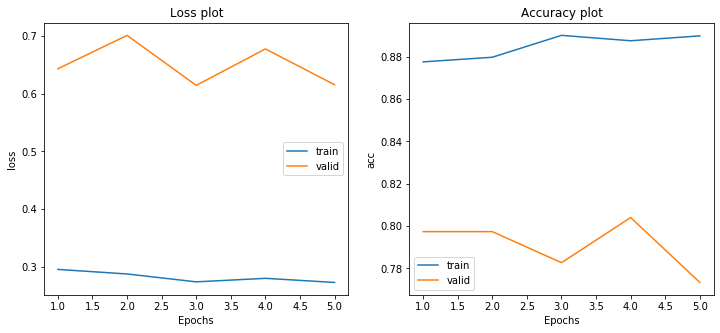

In [0]:
# plot the model loss and accuracy
train_loss = history.history['loss']
train_acc = history.history['acc']

valid_loss = history.history['val_loss']
valid_acc = history.history['val_acc']

x = [(i+1) for i in range(len(train_loss))]

f,ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(x, train_loss)
ax[0].plot(x, valid_loss)
ax[0].set_title("Loss plot")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'valid'])


ax[1].plot(x, train_acc)
ax[1].plot(x, valid_acc)
ax[1].set_title("Accuracy plot")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("acc")
ax[1].legend(['train', 'valid'])

plt.show()

In [0]:
test_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255,
                             #rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/40X_Norm/",
                                            class_mode="categorical",
                                            target_size=(64,64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 160 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

5/5 [==============================] - 50s 10s/step
0.6375


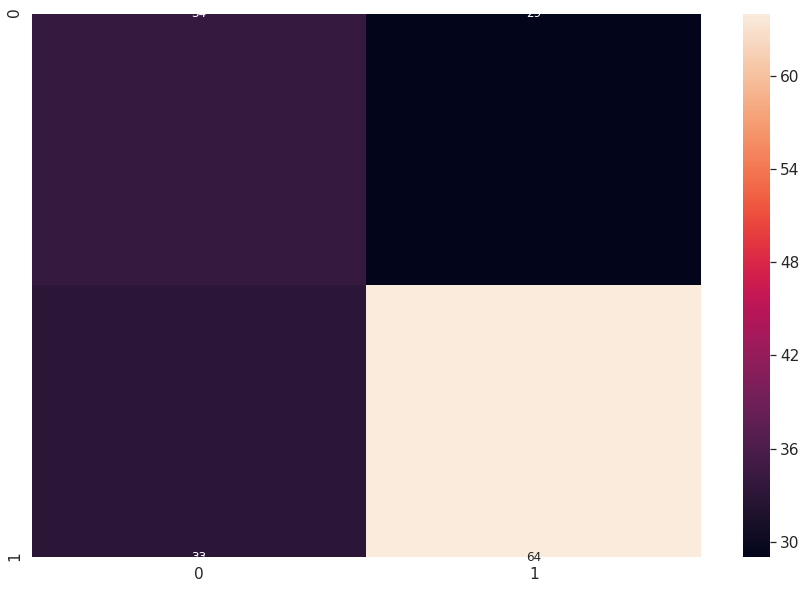

array([[34, 29],
       [33, 64]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
test_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.4,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/100X_Norm/",
                                            class_mode="categorical",
                                            target_size=(64, 64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 209 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

7/7 [==============================] - 66s 9s/step
0.8373205750182485


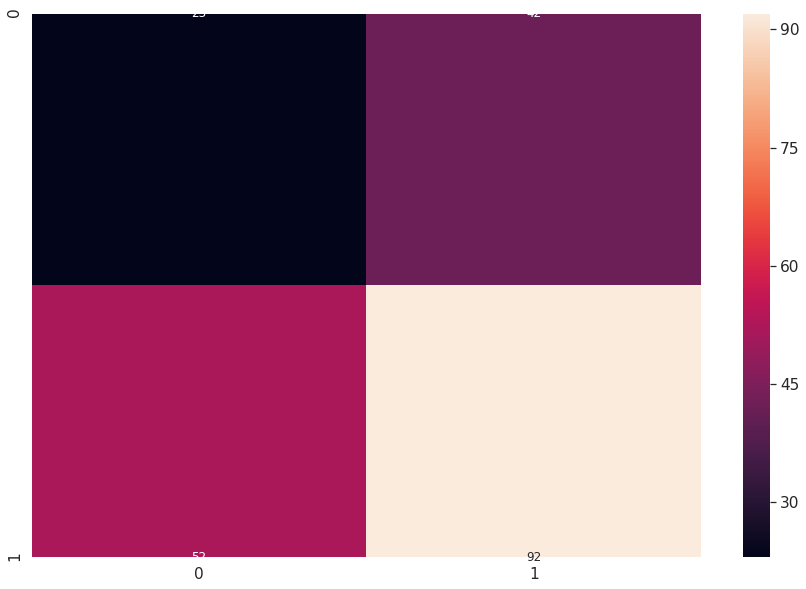

array([[23, 42],
       [52, 92]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
test_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.4,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/200X_Norm/",
                                            class_mode="categorical",
                                            target_size=(64, 64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 202 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

7/7 [==============================] - 72s 10s/step
0.8514851491049965


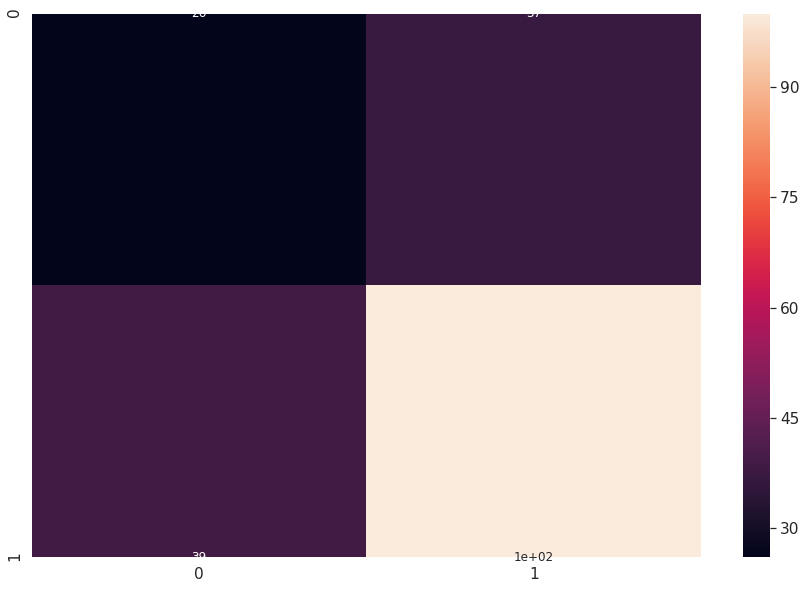

array([[ 26,  37],
       [ 39, 100]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
test_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test_mix_Norm/",
                                            class_mode="categorical",
                                            target_size=(64, 64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 754 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

24/24 [==============================] - 210s 9s/step
0.720159151826044


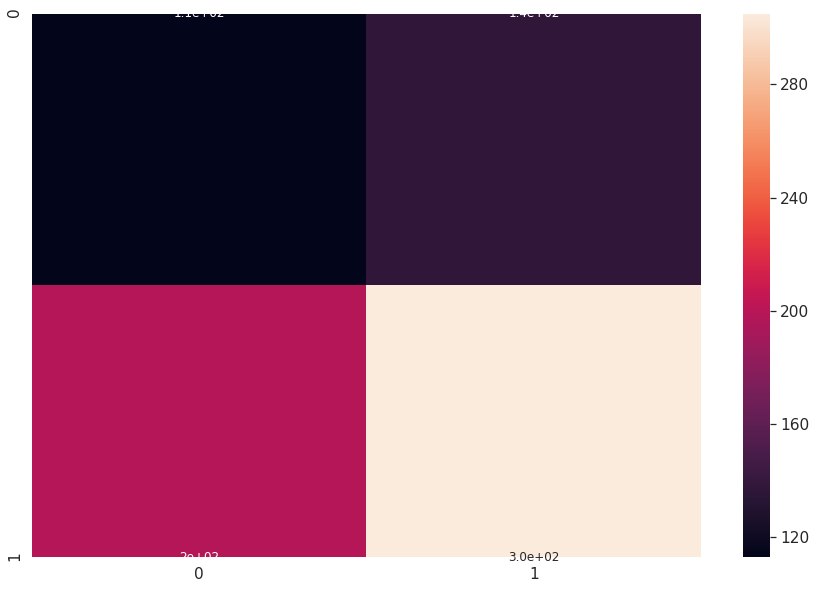

array([[113, 137],
       [199, 305]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm

In [0]:
test_gen=ImageDataGenerator(rotation_range=60,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             rescale = 1./255, 
                             shear_range = 0.2,
                             zoom_range = 0.5,
                             horizontal_flip = True,
                             #featurewise_std_normalization=True,
                             fill_mode="nearest")

test = test_gen.flow_from_directory("/content/gdrive/My Drive/breast_cancer/fold1/test/400X_Norm/",
                                            class_mode="categorical",
                                            target_size=(64, 64),
                                            color_mode="rgb",
                                            shuffle=True,
                                            batch_size=32)

Found 183 images belonging to 2 classes.


In [0]:
loss,test_acc = model.evaluate_generator(
    test,
    steps=len(test),
    verbose=1
)

print(test_acc)

6/6 [==============================] - 48s 8s/step
0.7814207627473633


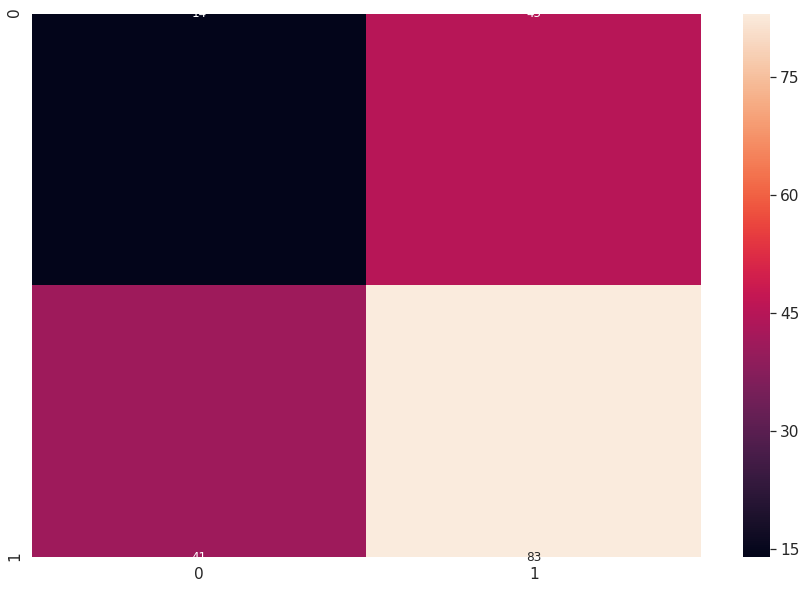

array([[14, 45],
       [41, 83]])

In [0]:
pred = model.predict_generator(test, steps=len(test))
predicted = np.argmax(pred, axis=1)

cm = confusion_matrix(test.classes, predicted)
plt.figure(figsize = (15,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
cm